# EndTailImputer

The EndTailImputer() replaces missing data by a value at either tail of the distribution. It automatically determines the value to be used in the imputation using the mean plus or minus a factor of the standard deviation, or using the inter-quartile range proximity rule. Alternatively, it can use a factor of the maximum value.

The EndTailImputer() is in essence, very similar to the ArbitraryNumberImputer, but it selects the value to use fr the imputation automatically, instead of having the user pre-define them.

It works only with numerical variables.

**For this demonstration, we use the Ames House Prices dataset produced by Professor Dean De Cock:**

[Dean De Cock (2011) Ames, Iowa: Alternative to the Boston Housing
Data as an End of Semester Regression Project, Journal of Statistics Education, Vol.19, No. 3](http://jse.amstat.org/v19n3/decock.pdf)

The version of the dataset used in this notebook can be obtained from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)

## Version

In [34]:
# Make sure you are using this 
# Feature-engine version.

import feature_engine

feature_engine.__version__

'1.6.2'

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from feature_engine.imputation import EndTailImputer

## Load data

In [36]:
# # Download the data from Kaggle and store it in the same folder as this notebook.
# data = pd.read_csv('../data/housing.csv')
# data.head()

# # Separate the data into train and test sets.
# X_train, X_test, y_train, y_test = train_test_split(
#     data.drop(['Id', 'SalePrice'], axis=1),
#     data['SalePrice'],
#     test_size=0.3,
#     random_state=0,
# )

# X_train.shape, X_test.shape

In [37]:
# Read the separate files
train_df = pd.read_csv('../data/house-prices/train.csv')
test_df = pd.read_csv('../data/house-prices/test.csv')

# Separate features and target in training data
X_train = train_df.drop(['Id', 'SalePrice'], axis=1)
y_train = train_df['SalePrice']

# For test data, you might not have the target variable
X_test = test_df.drop(['Id'], axis=1)  # Note: test data might not have SalePrice column

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)

X_train : (1460, 79)
X_test : (1459, 79)


## Check missing data

In [38]:
# numerical variables with missing data

X_train[['LotFrontage', 'MasVnrArea']].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
dtype: float64

The EndTailImputer can replace NA with a value at the left or right end of the distribution.

In addition, it uses 3 different methods to identify the imputation values.

In the following cells, we show how to use each method.

## Gaussian, right tail

Let's begin by finding the values automatically at the right tail, by using the mean and the standard deviation.

In [39]:
imputer = EndTailImputer(
    # uses mean and standard deviation to determine the value
    imputation_method='gaussian',
    # value at right tail of distribution
    tail='right',
    # multiply the std by 3
    fold=3,
    # the variables to impute
    variables=['LotFrontage', 'MasVnrArea'],
)

In [40]:
# find the imputation values
imputer.fit(X_train)

EndTailImputer(variables=['LotFrontage', 'MasVnrArea'])

In [41]:
# The values for the imputation
imputer.imputer_dict_

{'LotFrontage': 142.9042136914763, 'MasVnrArea': 646.8838814696388}

Note that we use different values for different variables.

In [42]:
# impute the data
train_t = imputer.transform(X_train)
test_t = imputer.transform(X_test)

In [43]:
# check we no longer have NA
train_t['LotFrontage'].isnull().sum()

0

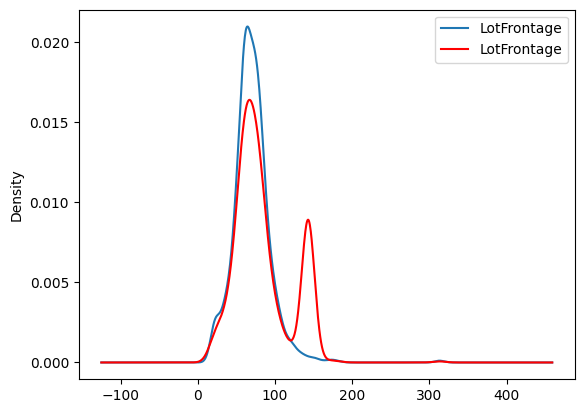

In [44]:
# The variable distribution changed slightly with more values accumulating towards the right tail
fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

## IQR, left tail

Now, we will impute variables with values at the left tail. The values are identified using the inter-quartile range proximity rule. 

The IQR rule is better suited for skewed variables.

In [45]:
imputer = EndTailImputer(
    
    # uses the inter-quartile range proximity rule
    imputation_method='iqr',
    
    # determines values at the left tail of the distribution
    tail='left',
    
    # multiplies the IQR by 3
    fold=3,
    
    # the variables to impute
    variables=['LotFrontage', 'MasVnrArea'],
)

In [46]:
# finds the imputation values

imputer.fit(X_train)

EndTailImputer(imputation_method='iqr', tail='left',
               variables=['LotFrontage', 'MasVnrArea'])

In [47]:
# imputation values per variable

imputer.imputer_dict_

{'LotFrontage': -4.0, 'MasVnrArea': -498.0}

In [48]:
# transform the data

train_t = imputer.transform(X_train)
test_t = imputer.transform(X_test)

In [49]:
# Check we have no NA after the transformation

train_t[['LotFrontage', 'MasVnrArea']].isnull().sum()

LotFrontage    0
MasVnrArea     0
dtype: int64

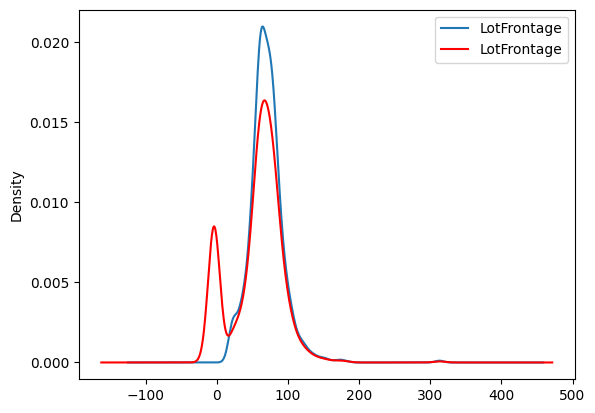

In [50]:
# The variable distribution changed with the
# transformation, with more values
# accumulating towards the left tail.

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

## Impute with the maximum value

We can find imputation values with a factor of the maximum variable value.

In [51]:
imputer = EndTailImputer(
    
    # imputes beyond the maximum value
    imputation_method='max',
    
    # multiplies the maximum value by 3
    fold=3,
    
    # the variables to impute
    variables=['LotFrontage', 'MasVnrArea'],
)

In [52]:
# find imputation values

imputer.fit(X_train)

EndTailImputer(imputation_method='max', variables=['LotFrontage', 'MasVnrArea'])

In [53]:
# The imputation values.

imputer.imputer_dict_

{'LotFrontage': 939.0, 'MasVnrArea': 4800.0}

In [54]:
# the maximum values of the variables,
# note how the imputer multiplied them by 3
# to determine the imputation values.

X_train[imputer.variables_].max()

LotFrontage     313.0
MasVnrArea     1600.0
dtype: float64

In [55]:
# impute the data

train_t = imputer.transform(X_train)
test_t = imputer.transform(X_test)

In [56]:
# Check we have no NA  in the imputed data

train_t[['LotFrontage', 'MasVnrArea']].isnull().sum()

LotFrontage    0
MasVnrArea     0
dtype: int64

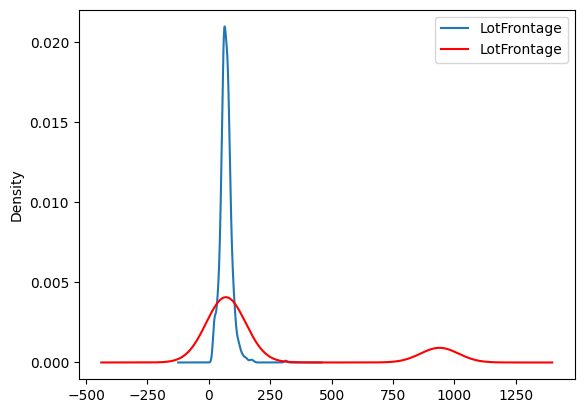

In [57]:
# The variable distribution changed with the
# transformation, with now more values
# beyond the maximum.

fig = plt.figure()
ax = fig.add_subplot(111)
X_train['LotFrontage'].plot(kind='kde', ax=ax)
train_t['LotFrontage'].plot(kind='kde', ax=ax, color='red')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

## Automatically impute all variables

As with all Feature-engine transformers, the EndTailImputer can also find and impute all numerical variables in the data.

In [58]:
# Start the imputer

imputer = EndTailImputer()

In [59]:
# Check the default parameters

# how to find the imputation value
imputer.imputation_method

'gaussian'

In [60]:
# which tail to use

imputer.tail

'right'

In [61]:
# how far out
imputer.fold

3

In [62]:
# Find variables and imputation values

imputer.fit(X_train)

EndTailImputer()

In [63]:
# The variables to impute

imputer.variables_

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [64]:
#  The imputation values

imputer.imputer_dict_

{'MSSubClass': 183.7989732554039,
 'LotFrontage': 142.9042136914763,
 'LotArea': 40460.62287932923,
 'OverallQual': 10.248304708717932,
 'OverallCond': 8.913740475891618,
 'YearBuilt': 2061.8765203467538,
 'YearRemodAdd': 2046.8019738477856,
 'MasVnrArea': 646.8838814696388,
 'BsmtFinSF1': 1811.9339985501804,
 'BsmtFinSF2': 530.5071334881184,
 'BsmtUnfSF': 1892.8412768362068,
 'TotalBsmtSF': 2373.5454254332067,
 '1stFlrSF': 2322.3899264519905,
 '2ndFlrSF': 1656.5777734121948,
 'LowQualFinSF': 151.71376484850578,
 'GrLivArea': 3091.9048488997446,
 'BsmtFullBath': 1.9820742840228442,
 'BsmtHalfBath': 0.7737921854129778,
 'FullBath': 3.21781589703698,
 'HalfBath': 1.891532855607441,
 'BedroomAbvGr': 5.313772488597069,
 'KitchenAbvGr': 1.7075899376178454,
 'TotRmsAbvGrd': 11.393988090930234,
 'Fireplaces': 2.5470128575668256,
 'GarageYrBlt': 2052.575338192645,
 'GarageCars': 4.0090683180045605,
 'GarageArea': 1114.3946613464427,
 'WoodDeckSF': 470.2609036031175,
 'OpenPorchSF': 245.4283570

In [65]:
# impute the data

train_t = imputer.transform(X_train)
test_t = imputer.transform(X_test)

In [66]:
# Sanity check:

# No numerical variable with NA is  left in the
# transformed data.

[v for v in train_t.columns if train_t[v].dtypes !=
    'O' and train_t[v].isnull().sum() > 1]

[]